# Multimedia Information Retrieval

The main objective for this project is ....

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2

# Extract local features

In [ ]:
def extract_descriptors(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # sift = cv2.SIFT_create()
    # keypoints, descriptors = sift.detectAndCompute(img_gray, None)

    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(img_gray, None)

    return keypoints, descriptors

def process(filename, draw_descriptors=False):
    img = cv2.imread(filename)
    keypoints, descriptors = extract_descriptors(img)

    if draw_descriptors:
        img_out = cv2.drawKeypoints(img, keypoints, img.copy())
        plt.figure(figsize=(14, 7))
        plt.subplot(121)
        plt.imshow(img)
        plt.subplot(122)
        plt.imshow(img_out)

    return descriptors

import os

filenames = [f'data/{x}/{filename}' for x in os.listdir('data') for filename in os.listdir(f'data/{x}')]

bag_features = []
for f in filenames:
    bag_features = bag_features + process(f).tolist()


# Create dictionary of descriptors

In [ ]:
def create_dict(bag, dict_size):
    bag = np.array(bag, dtype=np.float32)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 1.0)
    ret, label, center = cv2.kmeans(bag, dict_size, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # retorna a lista de centroides de cada grupo
    return center

dict_size = 50

# bag of visual words
bovw = create_dict(bag_features, dict_size)

# Trecho nativo de código para salvar o dicionario em um formato 
# nativo do python para facilitar leitura posterior
pickle.dump(bovw, open("bovw.pkl", "wb"))

# Create histograms for dataset

In [ ]:
def euclidean_distance(pt1, pt2):
    return cv2.norm(np.float32(pt1), np.float32(pt2), cv2.NORM_L2)

def create_histogram(filename):
    des = process(filename)
    score = np.zeros(len(bovw)).astype(np.float32)

    for d in des:
        best = 0
        for j in range(len(bovw)):
            if euclidean_distance(d, bovw[j]) < euclidean_distance(d, bovw[best]):
                best = j
        score[best] += 1
    return score

histograms = [create_histogram(f) for f in filenames]

# Compare input image with dataset

In [ ]:
def compare_histograms(h1, h2):
    method = cv2.HISTCMP_BHATTACHARYYA
    return cv2.compareHist(h1, h2, method)

filename = "data/cow/_3.jpeg"

input_desc = process(filename)
input_hist = create_histogram(filename)

results = []
for i in range(len(histograms)):
    dist = compare_histograms(input_hist, histograms[i])
    results.append([filenames[i], dist])

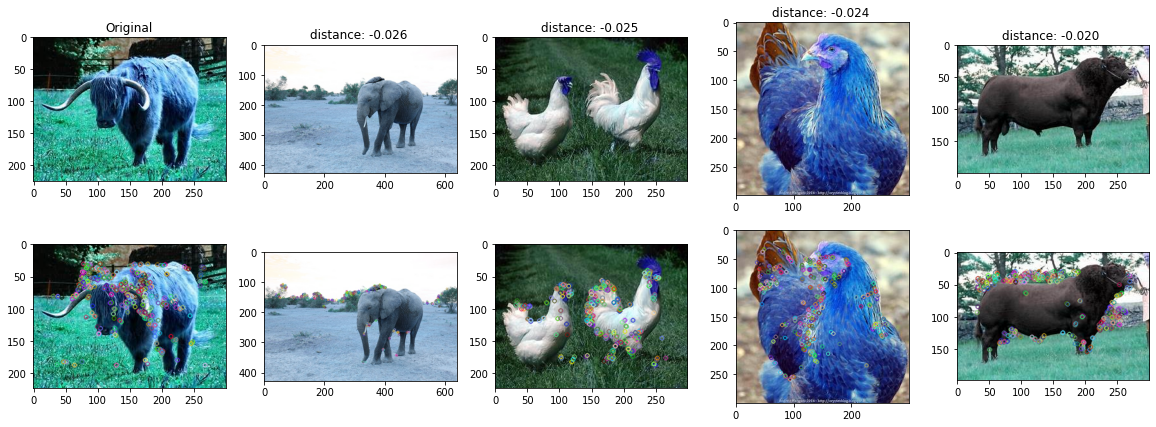

In [ ]:
results = np.array(results)
results = results[results[:, 1].argsort()][::-1][:4]

plt.figure(figsize=(20, 7))

plt.subplot(251)
plt.imshow(cv2.imread(filename))
plt.title('Original')
for i in range(len(results)):
    plt.subplot(2, 5, i + 2)
    plt.imshow(cv2.imread(results[i][0]))
    plt.title('distance: %.3f ' % (float(results[i][1])))

plt.subplot(256)
img = cv2.imread(filename)
keypoints, descriptors = extract_descriptors(img)
plt.imshow(cv2.drawKeypoints(img, keypoints, img.copy()))
for i in range(len(results)):
    plt.subplot(2, 5, i + 7)

    img = cv2.imread(results[i][0])
    keypoints, descriptors = extract_descriptors(img)
    plt.imshow(cv2.drawKeypoints(img, keypoints, img.copy()))


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c49759d8-944a-4cb2-ae9b-3a17004d3b2a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>